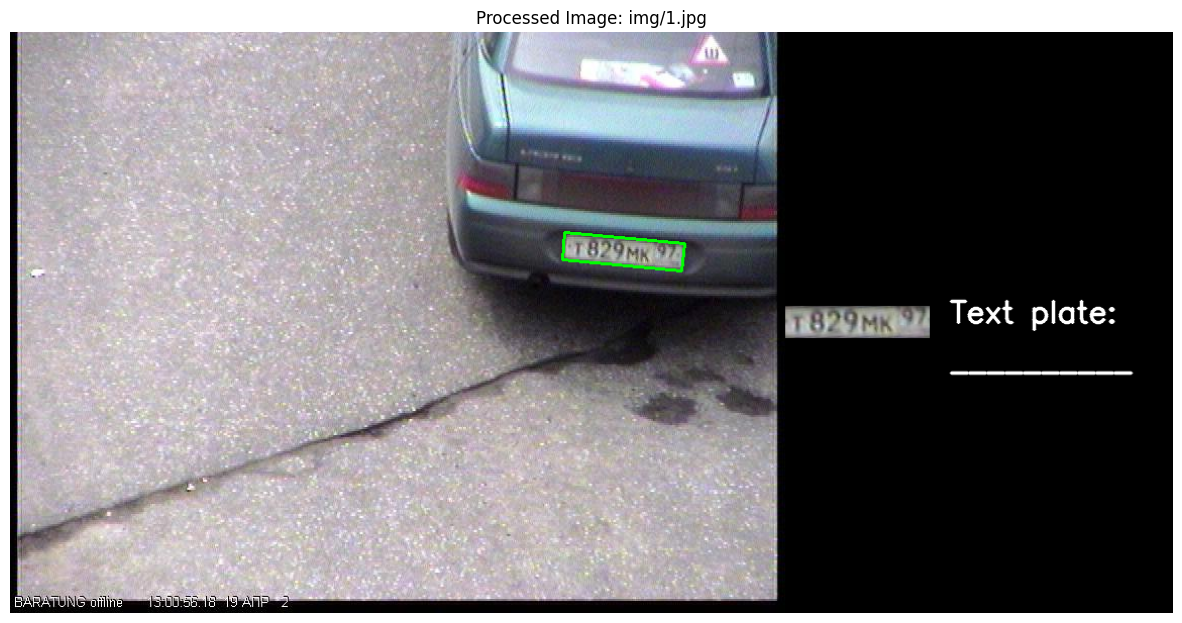

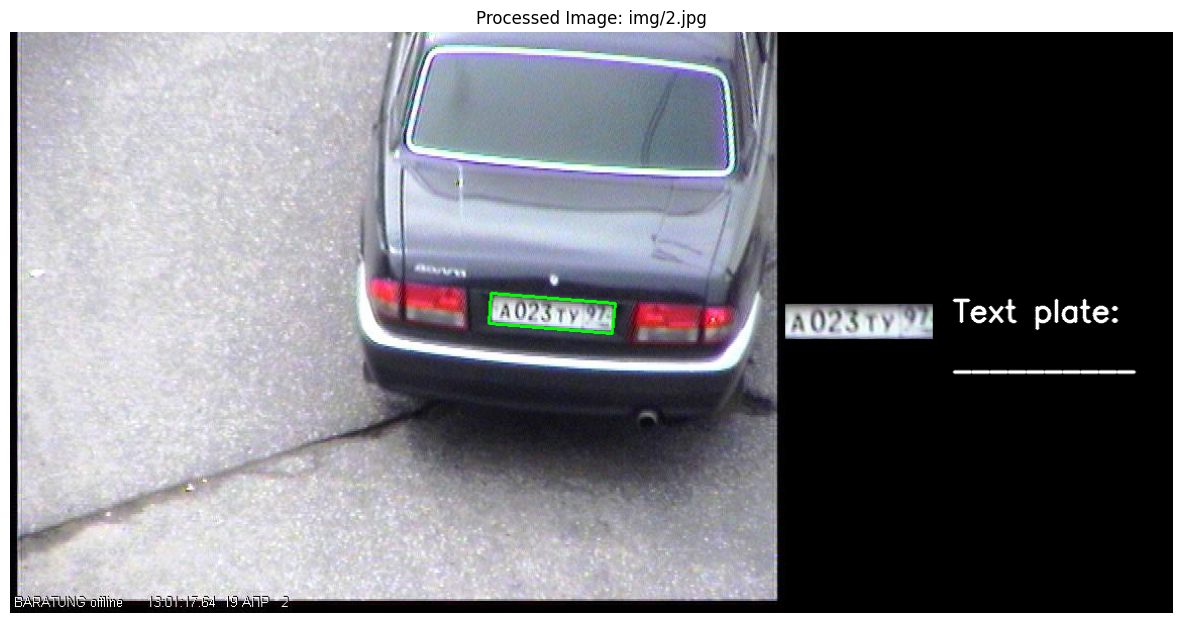

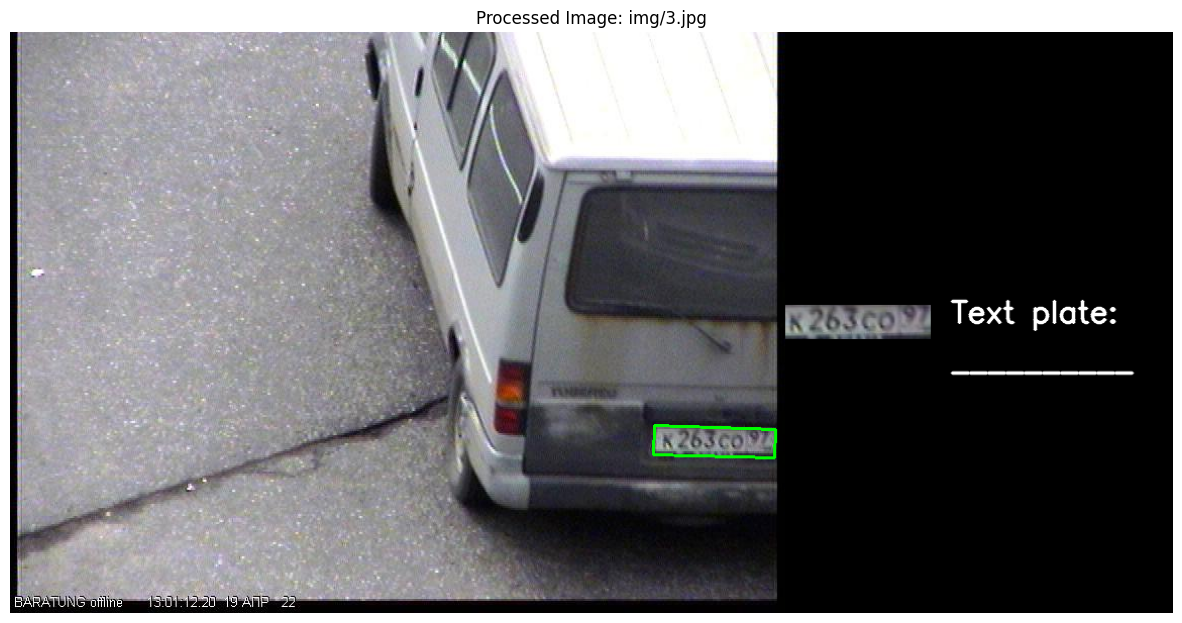

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def get_transform(image, pts, padding=0.1):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))
    center = np.mean(rect, axis=0)
    vectors = rect - center
    rect_shrinked = rect - vectors * padding
    rect_shrinked[:, 0] = np.clip(rect_shrinked[:, 0], 0, image.shape[1] - 1)
    rect_shrinked[:, 1] = np.clip(rect_shrinked[:, 1], 0, image.shape[0] - 1)
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(rect_shrinked, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def get_transformed_plate(image, bbox, padding=0.1):
    plate = get_transform(image, bbox, padding)
    return plate

def process_and_display_plate(image_path, padding=0.1):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at path: {image_path}")
        return
    output_image = image.copy()
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 100, 200, cv2.THRESH_TOZERO_INV)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    plate_found = False
    plate_image = None
    plate_box = None
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        aspectRatio = float(w) / h
        if aspectRatio >= 3 and area > 600:
            approx = cv2.approxPolyDP(cnt, 0.05 * cv2.arcLength(cnt, True), True)
            if len(approx) <= 4 and x > 15:
                rect = cv2.minAreaRect(cnt)
                box = cv2.boxPoints(rect)
                box = np.intp(box)
                plate_image = get_transformed_plate(image, box, padding)
                plate_found = True
                plate_box = box
                break
    if plate_found:
        cv2.polylines(output_image, [plate_box], isClosed=True, color=(0, 255, 0), thickness=2)
    height, width = image.shape[:2]
    black_space_width = width // 2
    black_space = np.zeros((height, black_space_width, 3), dtype=np.uint8)
    if plate_found and plate_image is not None:
        plate_height, plate_width = plate_image.shape[:2]
        scale_factor = min(black_space_width / (plate_width + 200), height / plate_height)
        new_plate_width = int(plate_width * scale_factor)
        new_plate_height = int(plate_height * scale_factor)
        resized_plate = cv2.resize(plate_image, (new_plate_width, new_plate_height), interpolation=cv2.INTER_AREA)
        y_offset = (height - new_plate_height) // 2
        black_space[y_offset:y_offset + new_plate_height, 0:new_plate_width] = resized_plate
        placeholder_text = "Text plate:"
        decoded_text = "__________"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_color = (255, 255, 255)
        thickness = 2
        line_type = cv2.LINE_AA
        cv2.putText(black_space, placeholder_text, (new_plate_width + 20, y_offset + new_plate_height // 2), 
                    font, font_scale, font_color, thickness, line_type)
        cv2.putText(black_space, decoded_text, (new_plate_width + 20, y_offset + new_plate_height // 2 + 50), 
                    font, font_scale, font_color, thickness, line_type)
    else:
        placeholder_text = "Not found."
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_color = (0, 0, 255)
        thickness = 2
        line_type = cv2.LINE_AA
        text_size, _ = cv2.getTextSize(placeholder_text, font, font_scale, thickness)
        text_x = (black_space_width - text_size[0]) // 2
        text_y = height // 2
        cv2.putText(black_space, placeholder_text, (text_x, text_y), 
                    font, font_scale, font_color, thickness, line_type)
    combined_image = np.hstack((output_image, black_space))
    combined_image_rgb = cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15, 10))
    plt.imshow(combined_image_rgb)
    plt.axis('off')
    plt.title(f'Processed Image: {image_path}')
    plt.show()

images = ['img/1.jpg', 'img/2.jpg', 'img/3.jpg']

for img_path in images:
    process_and_display_plate(img_path, padding=0.1)


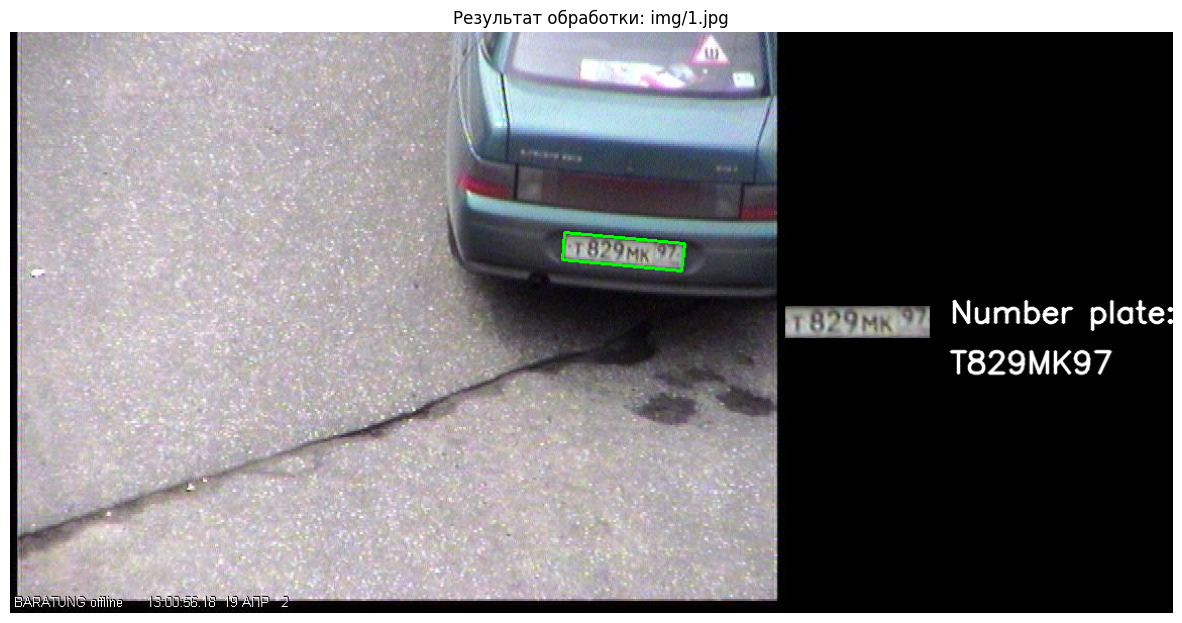

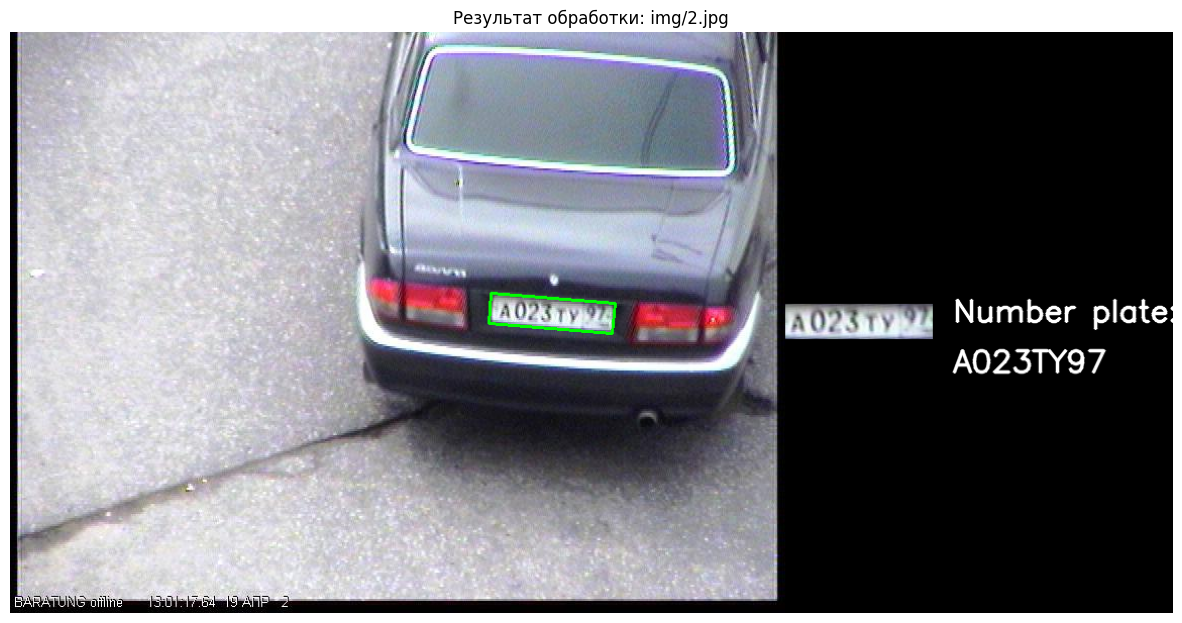

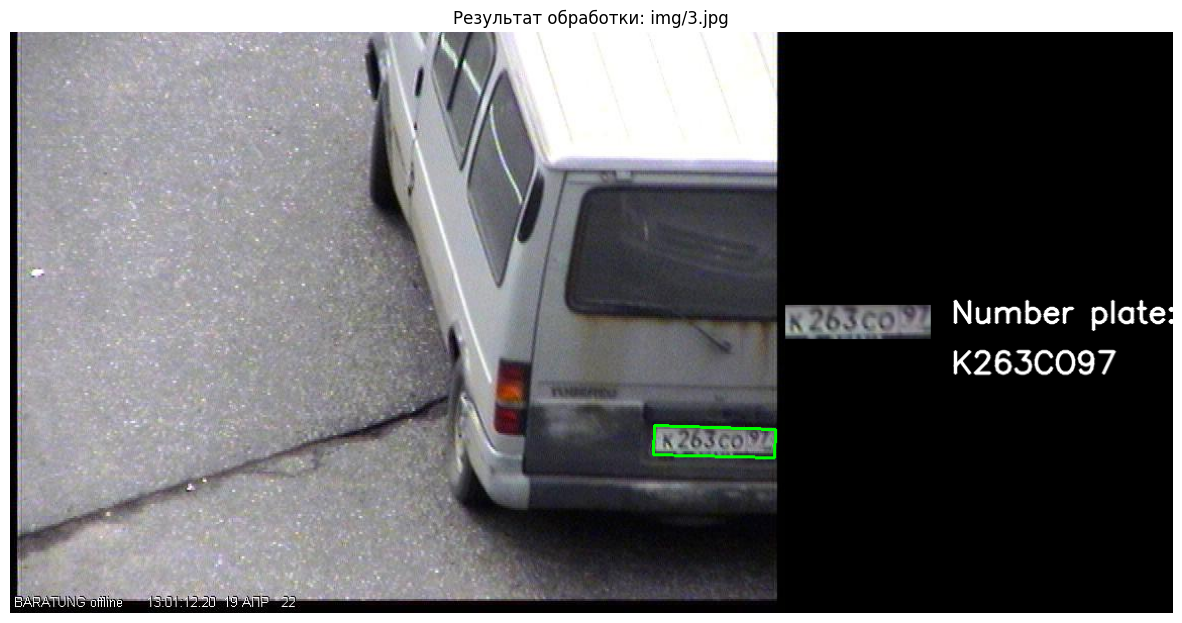

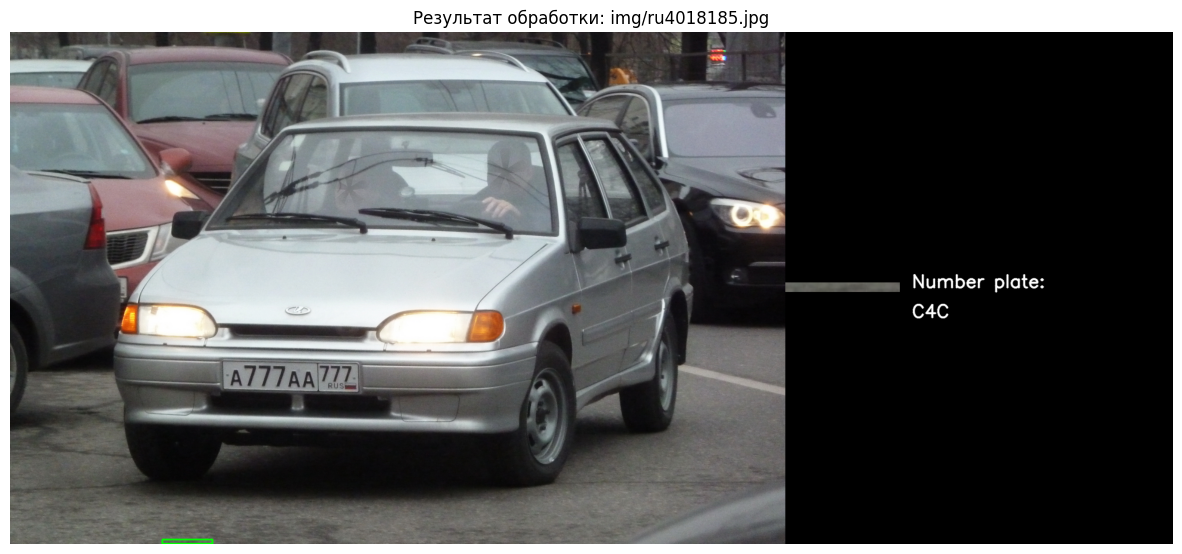

In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

# Конфигурация устройства
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Классы символов для модели OCR
CLASSES = "ABEKMHOPCTYX0123456789"

# Трансформации для входных изображений
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.25,), (0.25,))
])

# Определение модели CNN
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(128),
            nn.AdaptiveAvgPool2d((1, 1))  # Глобальный Average Pooling
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 256),
            nn.SiLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Разворачиваем перед линейным слоем
        x = self.fc_layers(x)
        return x
# Загрузка предобученной модели
model = ImprovedCNN(len(CLASSES)).to(DEVICE)
SAVE_PATH = "best_model_9.pth"
try:
    model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
    model.eval()
except Exception as e:
    print(f"Ошибка при загрузке модели: {e}")

# Функции для распознавания номера
def extract_symbols(image, masks):
    img_h, img_w = image.shape
    symbols = []
    for bbox in masks:
        x_frac, y_frac, w_frac, h_frac = bbox
        x = int(x_frac * img_w)
        y = int(y_frac * img_h)
        w = int(w_frac * img_w)
        h = int(h_frac * img_h)
        x_end = min(x + w, img_w)
        y_end = min(y + h, img_h)
        symbol = image[y:y_end, x:x_end]
        if symbol.size == 0:
            continue
        symbols.append(symbol)
    return symbols

def is_symbol_present(symbol, threshold=250):
    return np.mean(symbol) < threshold

expected_types_8 = ['letter', 'digit', 'digit', 'digit', 'letter', 'letter', 'digit', 'digit']
expected_types_9 = ['letter', 'digit', 'digit', 'digit', 'letter', 'letter', 'digit', 'digit', 'digit']

mask_8 = [
    (0.03, 0.05, 0.12, 0.9),
    (0.16, 0.05, 0.12, 0.9),
    (0.28, 0.05, 0.12, 0.9),
    (0.40, 0.05, 0.12, 0.9),
    (0.52, 0.05, 0.12, 0.9),
    (0.64, 0.05, 0.12, 0.9),
    (0.79, 0.07, 0.10, 0.60),
    (0.89, 0.07, 0.10, 0.60),
]

mask_9 = [
    (0.05, 0.2, 0.1, 0.6),
    (0.17, 0.2, 0.1, 0.6),
    (0.29, 0.2, 0.1, 0.6),
    (0.41, 0.2, 0.1, 0.6),
    (0.53, 0.2, 0.1, 0.6),
    (0.65, 0.2, 0.1, 0.6),
    (0.77, 0.2, 0.1, 0.6),
    (0.89, 0.2, 0.1, 0.6),
    (1.01, 0.2, 0.1, 0.6)
]

digits = set(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
letters = set([c for c in CLASSES if c.isalpha()])

def process_plate(plate):
    gray_plate = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    resized_plate = cv2.resize(gray_plate, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    blurred = cv2.GaussianBlur(resized_plate, (3, 3), 0)
    symbols_8 = extract_symbols(blurred, mask_8)
    symbols_9 = extract_symbols(blurred, mask_9)
    if len(symbols_9) == 9 and is_symbol_present(symbols_9[-1]):
        characters = symbols_9
        expected_types = expected_types_9
    else:
        characters = symbols_8
        expected_types = expected_types_8
    return blurred, characters, expected_types

def recognize_plate(plate_image):
    if plate_image is None:
        return None
    processed_plate, characters, expected_types = process_plate(plate_image)
    predictions = []
    for idx, (symbol_img, expected_type) in enumerate(zip(characters, expected_types)):
        input_tensor = transform(symbol_img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            indices = torch.argmax(probabilities, dim=1)
            predicted_label = CLASSES[indices[0]]
            if expected_type == 'letter':
                if predicted_label == '0':
                    predicted_label = 'O'
                elif predicted_label == '8':
                    predicted_label = 'B'
                if predicted_label not in letters:
                    continue
            elif expected_type == 'digit':
                if predicted_label == 'O':
                    predicted_label = '0'
                elif predicted_label == 'B':
                    predicted_label = '8'
                if predicted_label not in digits:
                    continue
            predictions.append(predicted_label)
    plate_number = ''.join(predictions)
    return plate_number

# Функции для обнаружения номера
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def get_transform(image, pts, padding=0.1):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))
    center = np.mean(rect, axis=0)
    vectors = rect - center
    rect_shrinked = rect - vectors * padding
    rect_shrinked[:, 0] = np.clip(rect_shrinked[:, 0], 0, image.shape[1] - 1)
    rect_shrinked[:, 1] = np.clip(rect_shrinked[:, 1], 0, image.shape[0] - 1)
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(rect_shrinked, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def get_transformed_plate(image, bbox, padding=0.1):
    plate = get_transform(image, bbox, padding)
    return plate

def process_and_display_plate(image_path, padding=0.1):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at path: {image_path}")
        return
    output_image = image.copy()
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 100, 200, cv2.THRESH_TOZERO_INV)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    plate_found = False
    plate_image = None
    plate_box = None
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        aspectRatio = float(w) / h
        if aspectRatio >= 3 and area > 600:
            approx = cv2.approxPolyDP(cnt, 0.05 * cv2.arcLength(cnt, True), True)
            if len(approx) <= 4 and x > 15:
                rect = cv2.minAreaRect(cnt)
                box = cv2.boxPoints(rect)
                box = np.intp(box)
                plate_image = get_transformed_plate(image, box, padding)
                plate_found = True
                plate_box = box
                break
    if plate_found:
        cv2.polylines(output_image, [plate_box], isClosed=True, color=(0, 255, 0), thickness=2)
        # Распознавание номера
        plate_number = recognize_plate(plate_image)
    else:
        plate_number = None

    height, width = image.shape[:2]
    black_space_width = width // 2
    black_space = np.zeros((height, black_space_width, 3), dtype=np.uint8)
    if plate_found and plate_image is not None:
        plate_height, plate_width = plate_image.shape[:2]
        scale_factor = min(black_space_width / (plate_width + 200), height / plate_height)
        new_plate_width = int(plate_width * scale_factor)
        new_plate_height = int(plate_height * scale_factor)
        resized_plate = cv2.resize(plate_image, (new_plate_width, new_plate_height), interpolation=cv2.INTER_AREA)
        y_offset = (height - new_plate_height) // 2
        black_space[y_offset:y_offset + new_plate_height, 0:new_plate_width] = resized_plate
        # Вывод распознанного номера
        if plate_number:
            placeholder_text = "Number plate:"
            decoded_text = plate_number
        else:
            placeholder_text = "Not found"
            decoded_text = ""
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_color = (255, 255, 255)
        thickness = 2
        line_type = cv2.LINE_AA
        cv2.putText(black_space, placeholder_text, (new_plate_width + 20, y_offset + new_plate_height // 2), 
                    font, font_scale, font_color, thickness, line_type)
        cv2.putText(black_space, decoded_text, (new_plate_width + 20, y_offset + new_plate_height // 2 + 50), 
                    font, font_scale, font_color, thickness, line_type)
    else:
        placeholder_text = "Not found"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_color = (0, 0, 255)
        thickness = 2
        line_type = cv2.LINE_AA
        text_size, _ = cv2.getTextSize(placeholder_text, font, font_scale, thickness)
        text_x = (black_space_width - text_size[0]) // 2
        text_y = height // 2
        cv2.putText(black_space, placeholder_text, (text_x, text_y), 
                    font, font_scale, font_color, thickness, line_type)
    combined_image = np.hstack((output_image, black_space))
    combined_image_rgb = cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15, 10))
    plt.imshow(combined_image_rgb)
    plt.axis('off')
    plt.title(f'Результат обработки: {image_path}')
    plt.show()

# Обработка изображений
images = ['img/1.jpg', 'img/2.jpg', 'img/3.jpg', 'img/ru4018185.jpg']

for img_path in images:
    process_and_display_plate(img_path, padding=0.1)
